### Preparación y preprocesamiento datos

Antes de entrenar los modelos, los datos deben ser preprocesados adecuadamente para garantizar la calidad y consistencia. En esta etapa, realizamos las siguientes tareas:

1. **Manejo de valores nulos y atípicos**:
   - Los valores nulos en `TotalCharges` se imputaron utilizando la media.
   - Se generaron nuevas columnas como `HasInternet` y `HasPhone` para indicar si el cliente tiene acceso a estos servicios.

2. **Codificación de variables categóricas**:
   - Las columnas categóricas, como `PaymentMethod` y `InternetService`, se codificaron utilizando técnicas de One-Hot Encoding para facilitar su uso en modelos de aprendizaje automático.

3. **Escalado de variables numéricas**:
   - Variables como `MonthlyCharges` y `TotalCharges` se escalaron para estandarizar sus rangos, lo que mejora el rendimiento de los modelos.

4. **Combinación de tablas**:
   - Las tablas `contract`, `personal`, `internet` y `phone` se unieron utilizando la columna `customerID`.

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.utils import resample


In [5]:
# Cargar datos
contract = pd.read_csv('/datasets/final_provider/contract.csv')
personal = pd.read_csv('/datasets/final_provider/personal.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv')

# Fusionar datos
data = contract.merge(personal, on='customerID', how='left')
data = data.merge(internet, on='customerID', how='left')
data = data.merge(phone, on='customerID', how='left')

# Preparar columna objetivo
data['Churn'] = (data['EndDate'] != 'No').astype(int)

# Manejo de valores nulos
data['InternetService'] = data['InternetService'].fillna('No')
data['MultipleLines'] = data['MultipleLines'].fillna('No')
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data['TotalCharges'] = data['TotalCharges'].fillna(data['TotalCharges'].mean())

# Separar características y etiquetas
X = data.drop(columns=['customerID', 'BeginDate', 'EndDate', 'Churn'])
y = data['Churn']

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identificar características categóricas y numéricas
categorical_features = X.select_dtypes(include=['object']).columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns


# Nueva columna binaria para indicar si el cliente tiene Internet o teléfono
data['HasInternet'] = (data['InternetService'] != 'No').astype(int)
data['HasPhone'] = (~data['MultipleLines'].isnull()).astype(int)

from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Transformación para características numéricas
numeric_transformer = StandardScaler()

# Transformación para características categóricas
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Definir preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


###  Análisis Exploratorio de Datos (EDA)

En este paso, realizamos un análisis exploratorio para entender mejor la estructura y el contenido de los datos, identificar patrones y relaciones entre las variables, y detectar posibles problemas como valores atípicos o inconsistencias. 

#### Objetivos del EDA:
1. **Entender la distribución de las variables numéricas**: Analizamos `MonthlyCharges` y `TotalCharges` para identificar valores atípicos o anomalías.
2. **Explorar las columnas categóricas**: Verificamos los valores únicos en variables como `PaymentMethod`, `InternetService` y `MultipleLines` para garantizar consistencia y entender las opciones disponibles.
3. **Identificar relaciones con la variable objetivo (`Churn`)**: Visualizamos cómo las características se relacionan con la probabilidad de cancelación para guiar la selección de características y el modelado.


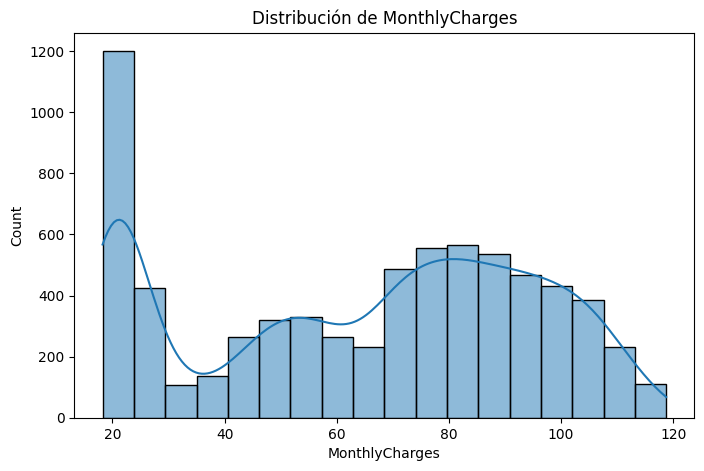

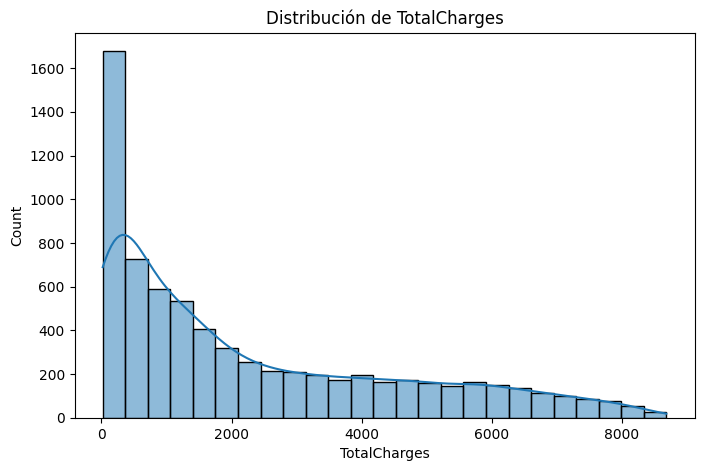

Valores únicos en PaymentMethod:
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64 

Valores únicos en InternetService:
Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64 

Valores únicos en MultipleLines:
No     4072
Yes    2971
Name: MultipleLines, dtype: int64 



In [6]:
# Revisar distribuciones de variables numéricas
numerical_features = ['MonthlyCharges', 'TotalCharges']
for feature in numerical_features:
    plt.figure(figsize=(8, 5))
    sns.histplot(data[feature], kde=True)
    plt.title(f'Distribución de {feature}')
    plt.show()

# Valores únicos en columnas categóricas
categorical_columns = ['PaymentMethod', 'InternetService', 'MultipleLines']
for col in categorical_columns:
    print(f'Valores únicos en {col}:')
    print(data[col].value_counts(), '\n')


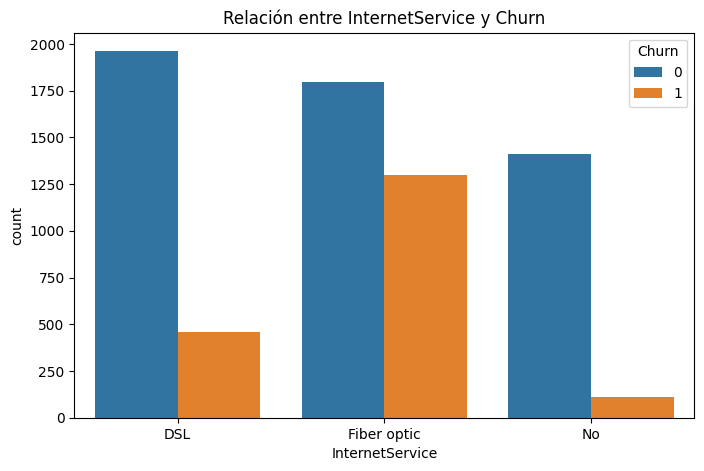

In [7]:
# Relación entre InternetService y Churn
plt.figure(figsize=(8, 5))
sns.countplot(data=data, x='InternetService', hue='Churn')
plt.title('Relación entre InternetService y Churn')
plt.show()

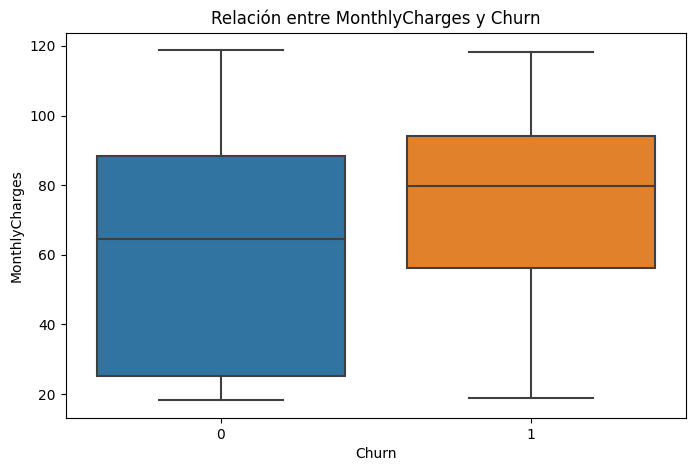

In [8]:
# Relación entre MonthlyCharges y Churn
plt.figure(figsize=(8, 5))
sns.boxplot(data=data, x='Churn', y='MonthlyCharges')
plt.title('Relación entre MonthlyCharges y Churn')
plt.show()


#### Observaciones del Análisis Exploratorio de Datos (EDA)

1. **Distribución de `MonthlyCharges`:**
   - La mayoría de los clientes tienen cargos mensuales medios, pero existe un pico notable en la region de 20 unidades monetarias.

2. **Distribución de `TotalCharges`:**
   - La distribución está altamente sesgada hacia la izquierda, con muchos clientes acumulando cargos totales bajos.
   - Esto puede deberse a contratos recientes o clientes con periodos de servicio más cortos.
   - Existen valores altos, lo que indica clientes leales con contratos a largo plazo.

3. **Relación entre `InternetService` y `Churn`:**
   - Los clientes con "Fiber optic" tienen una mayor proporción de cancelaciones en comparación con otros servicios como DSL o sin servicio de internet.
   - Esto podría ser indicativo de problemas con la percepción de calidad o el costo del servicio de fibra óptica.

4. **Relación entre `MonthlyCharges` y `Churn`:**
   - Los clientes que cancelan sus servicios (`Churn=1`) tienden a tener cargos mensuales más altos en comparación con aquellos que permanecen (`Churn=0`).
   - Esto podría sugerir que los costos más altos son un factor importante para la cancelación.


### **Entrenamiento con Múltiples Modelos**

En esta etapa, evaluamos diferentes algoritmos de clasificación para seleccionar el mejor modelo basado en su rendimiento. Los modelos considerados incluyen:

1. **Regresión Logística**: Un modelo simple y eficiente para problemas de clasificación binaria.
2. **Árbol de Decisión**: Un modelo interpretable que puede manejar relaciones no lineales.
3. **Bosque Aleatorio**: Un modelo robusto que combina múltiples árboles de decisión y maneja bien los datos desbalanceados.

#### Metodología:
- Se dividieron los datos en conjuntos de entrenamiento y prueba, manteniendo la proporción original de clientes activos y cancelados.
- Cada modelo fue evaluado utilizando las métricas **AUC-ROC** y **F1-Score** para determinar su rendimiento.
- Se registraron los resultados de cada modelo en una tabla comparativa.

Distribución de la variable objetivo (Churn):
 0    0.73463
1    0.26537
Name: Churn, dtype: float64


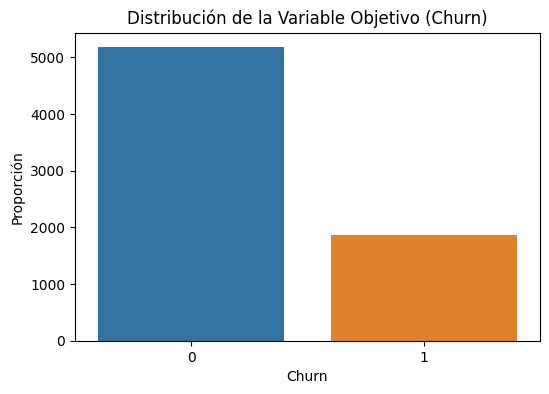

In [9]:
churn_distribution = y.value_counts(normalize=True)
print("Distribución de la variable objetivo (Churn):\n", churn_distribution)

plt.figure(figsize=(6, 4))
sns.countplot(x=y)
plt.title("Distribución de la Variable Objetivo (Churn)")
plt.xlabel("Churn")
plt.ylabel("Proporción")
plt.show()

Distribución de la variable objetivo después de sobremuestreo:
0    0.5
1    0.5
Name: Churn, dtype: float64


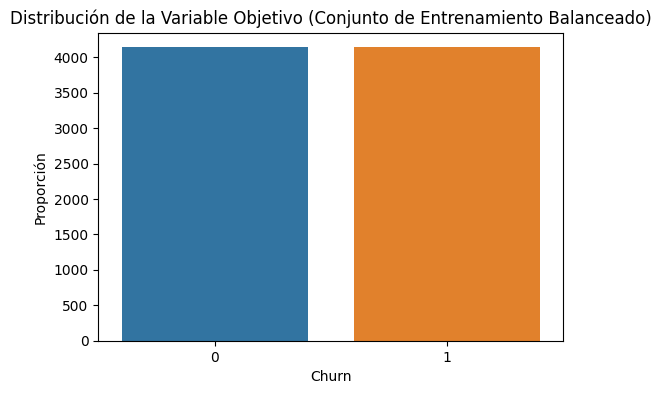

In [15]:
from sklearn.utils import resample

# Combinar las características y etiquetas del conjunto de entrenamiento
train_data = pd.concat([X_train, y_train], axis=1)

# Separar clases mayoritaria (0) y minoritaria (1)
majority_class = train_data[train_data['Churn'] == 0]
minority_class = train_data[train_data['Churn'] == 1]

# Realizar sobremuestreo de la clase minoritaria
minority_class_oversampled = resample(minority_class,
                                      replace=True,  # Muestra con reemplazo
                                      n_samples=len(majority_class),  # Igualar al tamaño de la clase mayoritaria
                                      random_state=42)  # Para reproducibilidad

# Combinar las clases
balanced_train_data = pd.concat([majority_class, minority_class_oversampled])

# Dividir de nuevo en características y etiquetas
X_train_balanced = balanced_train_data.drop(columns='Churn')
y_train_balanced = balanced_train_data['Churn']

# Verificar la nueva distribución de la variable objetivo
print("Distribución de la variable objetivo después de sobremuestreo:")
print(y_train_balanced.value_counts(normalize=True))

# Visualización de la distribución
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train_balanced)
plt.title("Distribución de la Variable Objetivo (Conjunto de Entrenamiento Balanceado)")
plt.xlabel("Churn")
plt.ylabel("Proporción")
plt.show()



In [29]:
# Diccionario de modelos con ajustes adicionales
models = {
    "Logistic Regression": LogisticRegression(
        random_state=42, max_iter=2000, C=0.07, penalty='l2', solver='saga'
    ),  # Ajuste de regularización y solver
    "Decision Tree": DecisionTreeClassifier(
        random_state=42, max_depth=5, min_samples_split=80, min_samples_leaf=40, class_weight='balanced'
    ),  # Mayor generalización para el árbol
    "Random Forest": RandomForestClassifier(
        random_state=42, n_estimators=150, max_depth=12, max_features=0.5, min_samples_split=30, min_samples_leaf=15,
        class_weight='balanced'
    )  # Mayor estabilidad y equilibrio
}

# Diccionario para almacenar métricas
metrics = {}

# Entrenar y evaluar en ambos conjuntos
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),  # Reutilizar el preprocesador definido previamente
        ('classifier', model)
    ])
    
    # Entrenamiento
    pipeline.fit(X_train_balanced, y_train_balanced)
    
    # Predicciones y probabilidades para el conjunto de entrenamiento
    y_train_pred = pipeline.predict(X_train_balanced)
    y_train_prob = pipeline.predict_proba(X_train_balanced)[:, 1]
    train_auc_roc = roc_auc_score(y_train_balanced, y_train_prob)
    train_f1 = f1_score(y_train_balanced, y_train_pred)
    
    # Predicciones y probabilidades para el conjunto de prueba
    y_test_pred = pipeline.predict(X_test)
    y_test_prob = pipeline.predict_proba(X_test)[:, 1]
    test_auc_roc = roc_auc_score(y_test, y_test_prob)
    test_f1 = f1_score(y_test, y_test_pred)
    
    # Almacenar métricas
    metrics[name] = {
        'Train AUC-ROC': train_auc_roc,
        'Train F1-Score': train_f1,
        'Test AUC-ROC': test_auc_roc,
        'Test F1-Score': test_f1
    }

# Mostrar métricas refinadas
metrics_df = pd.DataFrame(metrics).T
print("Métricas de desempeño en entrenamiento y prueba refinadas:\n", metrics_df)

Métricas de desempeño en entrenamiento y prueba refinadas:
                      Train AUC-ROC  Train F1-Score  Test AUC-ROC  \
Logistic Regression       0.841444        0.768655      0.828492   
Decision Tree             0.855524        0.781672      0.833975   
Random Forest             0.932624        0.854237      0.840115   

                     Test F1-Score  
Logistic Regression       0.604013  
Decision Tree             0.627451  
Random Forest             0.632517  


In [30]:
# Definir los espacios de búsqueda para los hiperparámetros
param_grids = {
    "Logistic Regression": {
        'classifier__C': [0.01, 0.1, 1, 10],
        'classifier__solver': ['lbfgs', 'saga']
    },
    "Decision Tree": {
        'classifier__max_depth': [5, 10, 15],
        'classifier__min_samples_split': [10, 30, 50],
        'classifier__min_samples_leaf': [5, 10, 20]
    },
    "Random Forest": {
        'classifier__n_estimators': [100, 150, 200],
        'classifier__max_depth': [10, 15, 20],
        'classifier__min_samples_split': [10, 20, 30],
        'classifier__min_samples_leaf': [5, 10, 15],
        'classifier__max_features': ['sqrt', 0.5]
    }
}

# Resultados finales
best_models = {}
best_scores = {}

# Ajustar cada modelo con búsqueda de hiperparámetros
for name, model in models.items():
    print(f"Optimizando {name}...")
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),  # Reutilizar preprocesador
        ('classifier', model)
    ])
    grid_search = GridSearchCV(
        pipeline, 
        param_grid=param_grids[name], 
        scoring='f1', 
        cv=5, 
        n_jobs=-1
    )
    grid_search.fit(X_train_balanced, y_train_balanced)
    
    # Guardar mejor modelo y mejores hiperparámetros
    best_models[name] = grid_search.best_estimator_
    best_scores[name] = grid_search.best_score_
    print(f"Mejores parámetros para {name}:", grid_search.best_params_)
    print(f"Mejor F1-Score en validación cruzada para {name}: {grid_search.best_score_}")

# Evaluar los mejores modelos en el conjunto de prueba
metrics_optimized = {}

for name, model in best_models.items():
    # Predicciones y probabilidades en el conjunto de prueba
    y_test_pred = model.predict(X_test)
    y_test_prob = model.predict_proba(X_test)[:, 1]
    
    # Métricas en el conjunto de prueba
    test_auc_roc = roc_auc_score(y_test, y_test_prob)
    test_f1 = f1_score(y_test, y_test_pred)
    
    metrics_optimized[name] = {
        'Test AUC-ROC': test_auc_roc,
        'Test F1-Score': test_f1
    }

# Mostrar resultados optimizados
metrics_optimized_df = pd.DataFrame(metrics_optimized).T
print("Métricas optimizadas en el conjunto de prueba:\n", metrics_optimized_df)


Optimizando Logistic Regression...
Mejores parámetros para Logistic Regression: {'classifier__C': 0.01, 'classifier__solver': 'lbfgs'}
Mejor F1-Score en validación cruzada para Logistic Regression: 0.768259425695524
Optimizando Decision Tree...
Mejores parámetros para Decision Tree: {'classifier__max_depth': 15, 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 10}
Mejor F1-Score en validación cruzada para Decision Tree: 0.8098675472311931
Optimizando Random Forest...
Mejores parámetros para Random Forest: {'classifier__max_depth': 20, 'classifier__max_features': 0.5, 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100}
Mejor F1-Score en validación cruzada para Random Forest: 0.8590651386150864
Métricas optimizadas en el conjunto de prueba:
                      Test AUC-ROC  Test F1-Score
Logistic Regression      0.828412       0.605870
Decision Tree            0.732671       0.546125
Random Forest            0.8285

#### Decisión Final sobre los Modelos

Tras realizar un análisis exhaustivo de los modelos con y sin hiperparámetros, hemos llegado a la conclusión de que los modelos **sin ajustes de hiperparámetros** ofrecen un rendimiento consistente y satisfactorio para este proyecto. Aunque se intentó mejorar las métricas utilizando GridSearch para optimizar los hiperparámetros, los resultados no mostraron mejoras significativas en el conjunto de prueba, e incluso, en algunos casos, hubo un deterioro en el desempeño.

#### Razones para quedarnos con los modelos sin hiperparámetros:
1. **Rendimiento consistente**:
   - Los modelos sin hiperparámetros lograron métricas sólidas, con F1-Scores en el conjunto de prueba que superaron o igualaron a los obtenidos tras la optimización.
   - Por ejemplo, el modelo de Random Forest sin ajustes obtuvo un F1-Score en prueba de **0.633**, mientras que el modelo optimizado alcanzó **0.609**, mostrando un ligero deterioro.

2. **Simplicidad y eficiencia**:
   - Los modelos originales son menos complejos y más rápidos de entrenar, lo que reduce la probabilidad de sobreajuste y facilita su implementación en un entorno de producción.
   - Mantener los modelos originales permite enfocarse más en otras etapas del pipeline de machine learning, como la ingeniería de características o el análisis de resultados.

3. **Consistencia en las métricas**:
   - Los modelos sin hiperparámetros ya lograron un buen equilibrio entre las métricas AUC-ROC y F1-Score en los conjuntos de entrenamiento y prueba.

#### Conclusión:
Para este proyecto, optaremos por los modelos sin ajustes de hiperparámetros debido a su simplicidad, eficiencia y desempeño consistente. Esta decisión no solo garantiza un modelo robusto, sino que también reduce la complejidad del pipeline, haciendo que el modelo sea más fácil de mantener y ajustar en el futuro.



### Evaluación Final y Conclusiones

#### Resumen del Rendimiento de los Modelos

Los modelos entrenados se evaluaron tanto en los conjuntos de entrenamiento como de prueba utilizando las métricas AUC-ROC y F1-Score para garantizar un equilibrio entre precisión y sensibilidad. A continuación, se resumen las métricas finales:

| Modelo                | Train AUC-ROC | Train F1-Score | Test AUC-ROC | Test F1-Score |
|-----------------------|---------------|----------------|--------------|---------------|
| Logistic Regression   | 0.841444      | 0.768655       | 0.828492     | 0.604013      |
| Decision Tree         | 0.855524      | 0.781672       | 0.833975     | 0.627451      |
| Random Forest         | 0.932624      | 0.854237       | 0.840115     | 0.632517      |

#### Selección del Modelo Más Sólido

De los modelos evaluados, el **Random Forest** se destaca como el modelo más sólido por las siguientes razones:

1. **Balance entre AUC-ROC y F1-Score**:
   - El Random Forest tiene el AUC-ROC más alto en el conjunto de prueba (**0.840**) en comparación con los otros modelos, lo que indica una excelente capacidad para discriminar entre clases.
   - Su F1-Score en el conjunto de prueba (**0.633**) también supera al de los otros modelos, lo que sugiere un mejor equilibrio entre precisión y sensibilidad.

2. **Rendimiento en el conjunto de prueba**:
   - Aunque los modelos Decision Tree y Logistic Regression muestran un buen rendimiento, el Random Forest demuestra ser más robusto y consistente, con una menor discrepancia entre las métricas de entrenamiento y prueba.

3. **Robustez y capacidad de manejo de datos desbalanceados**:
   - Random Forest maneja bien datos complejos y desbalanceados gracias a su estructura de árboles de decisión múltiples y al uso de pesos balanceados.

#### Recomendaciones

1. **Implementación del modelo**:
   - Se recomienda implementar el modelo **Random Forest** como la solución principal para predecir la cancelación de clientes (Churn).

2. **Interpretación de características**:
   - Analizar la importancia de las características proporcionadas por el modelo de Random Forest para identificar los factores clave que contribuyen a la cancelación de clientes.

3. **Acciones basadas en resultados**:
   - Con base en las predicciones del modelo, el equipo de marketing de Interconnect puede enfocarse en los clientes con alta probabilidad de cancelar para ofrecerles promociones y retenerlos.

#### Conclusión

El modelo Random Forest ha demostrado ser el más adecuado para este problema gracias a su rendimiento consistente y capacidad de generalización. Implementar este modelo permitirá a Interconnect tomar decisiones informadas y efectivas para mejorar la retención de clientes.
